In [ ]:
# importing rampy
import rampy as rp
# and for numpy we will respect the usual name:
import numpy as np
# for matplotlib
import matplotlib.pyplot as plt
from pydantic import BaseModel

# Experiment Subject 1

We performed OGTT on subject 1.

Here is the glucose concentration in blood during the 2 hour

| Time     | Concentration | filename |
|----------|---------------|----------|
| Predrink | 93            | pre      |
| 08:30    | 94            | 0        |
| 08:35    | 97            | 1        |
| 08:40    | 101           | 2        |
| 08:45    | 126           | 3        |
| 08:50    | 142           | 4        |
| 08:55    | 161           | 5        |
| 09:00    | 152           | 6        |
| 09:05    | 159           | 7        |
| 09:10    | 160           | 8        |
| 09:15    | 156           | 9        |
| 09:20    | 155           | 10       |
| 09:25    | 151           | 11       |
| 09:30    | 135           | 12       |
| 09:35    | 124           | 13       |
| 09:40    | 112           | 14       |
| 09:45    | 102           | 15       |
| 09:50    | 107           | 16       |
| 09:55    | 121           | 17       |
| 10:00    | 125           | 18       |
| 10:05    | 120           | 19       |
| 10:10    | 124           | 20       |
| 10:15    | 123           | 21       |
| 10:20    | 112           | 22       |
| 10:25    | 109           | 23       |
| 10:30    | 100           | 24       |

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the concentration over time
times = ["08:30","08:35","08:40","08:45","08:50","08:55","09:00","09:05","09:10","09:15","09:20","09:25","09:30","09:35","09:40","09:45","09:50","09:55","10:00","10:05","10:10","10:15","10:20","10:25","10:30"]
glucoses = [94,97,101,126,142,161,152,159,160,156,155,151,135,124,112,102,107,121,125,120,124,123,112,109,100]

for idx,t in enumerate(times):
    times[idx] = f"2024-03-19T{t}"

times = np.array(times, dtype="datetime64")

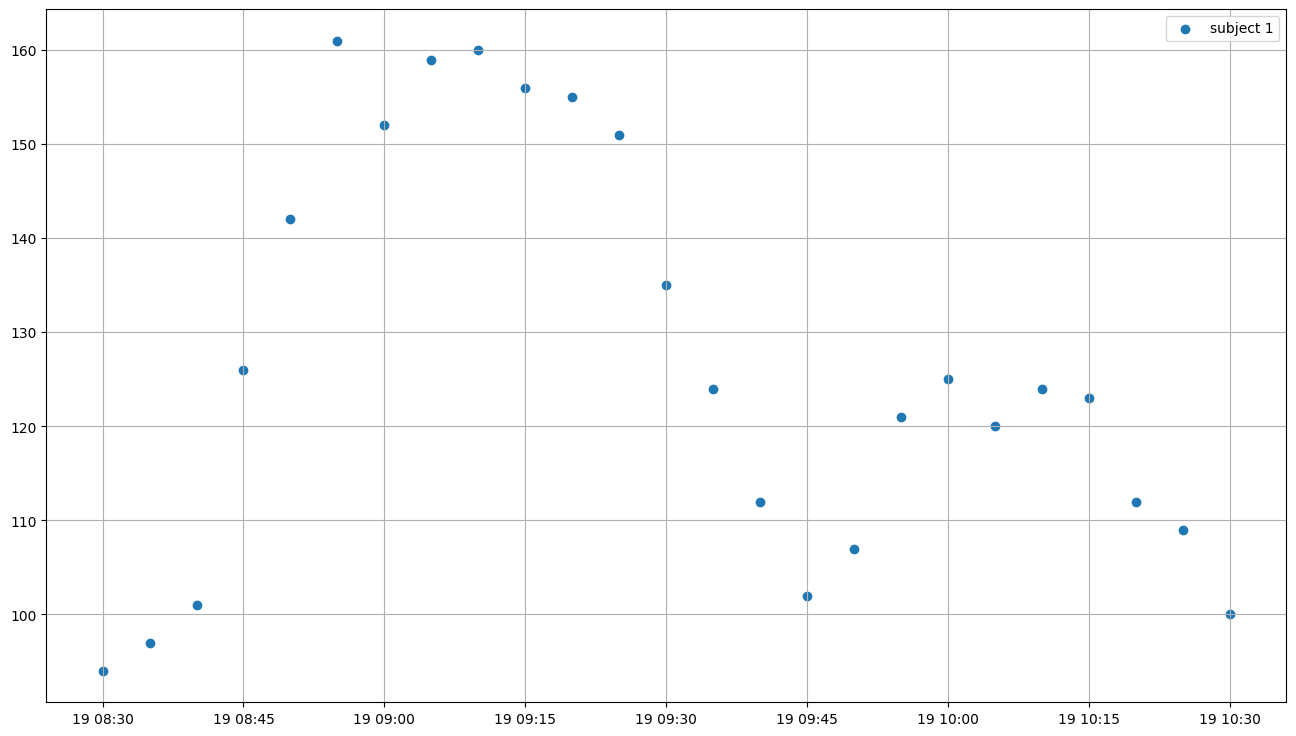

In [16]:

fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(times, glucoses, label="subject 1")
ax.grid()
ax.legend()
plt.show()